## Data extraction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.impute import KNNImputer
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.regularizers import l2

In [2]:
# Set option to display all columns

pd.set_option('display.max_columns', None)

# Read the CSV file into a DataFrame, using the first column as the index
data = pd.read_csv("healthcare-dataset-stroke-data-1.csv", index_col='Unnamed: 0')

In [3]:
data.drop('id',axis=1,inplace=True)

In [4]:
pipeline = Pipeline([
    # Drop NA values in object columns
    ('drop_na', FunctionTransformer(lambda X: X.dropna(subset=X.select_dtypes(include=['object']).columns), validate=False)),

    # One-hot encode categorical features
    ('encode_cat', ColumnTransformer([
        ('one_hot', OneHotEncoder(handle_unknown='ignore'), selector(dtype_include='object'))
    ], remainder='passthrough')),

    # Impute missing values using KNN
    ('impute', KNNImputer(n_neighbors=5)),

    # Remove outliers using Isolation Forest
    ('remove_outliers', FunctionTransformer(lambda data: data[np.array(IsolationForest(random_state=42).fit_predict(data[:, :-1])) == 1], validate=False))
])

# Fit the pipeline
pipeline.fit(data)

Pipeline(steps=[('drop_na',
                 FunctionTransformer(func=<function <lambda> at 0x00000211C4035750>)),
                ('encode_cat',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one_hot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000211C4016DD0>)])),
                ('impute', KNNImputer()),
                ('remove_outliers',
                 FunctionTransformer(func=<function <lambda> at 0x00000211C4035870>))])

In [5]:
data_prepared = pipeline.fit_transform(data)
# Get the OneHotEncoder from the pipeline
one_hot_encoder = pipeline.named_steps['encode_cat'].named_transformers_['one_hot']

# Get the feature names after one-hot encoding
encoded_columns = one_hot_encoder.get_feature_names_out(input_features=data.select_dtypes(include=['object']).columns.tolist())

# Concatenate encoded columns with numerical columns
all_column_names = list(encoded_columns) + data.select_dtypes(exclude=['object']).columns.tolist()

# Create DataFrame
data_prepared_df = pd.DataFrame(data_prepared, columns=all_column_names)

# Check the DataFrame
data_prepared_df

,gender_Female,gender_Male,gender_Other,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,49.0,0.0,0.0,171.23,34.40,1.0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,69.0,0.0,0.0,94.39,22.80,1.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,59.0,0.0,0.0,76.15,26.64,1.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,78.0,0.0,0.0,58.57,24.20,1.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,54.0,0.0,0.0,104.51,27.30,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2421,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,45.0,0.0,0.0,97.95,24.50,0.0
2422,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,57.0,0.0,0.0,77.93,21.70,0.0
2423,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,13.0,0.0,0.0,103.08,18.60,0.0
2424,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,80.0,1.0,0.0,83.75,27.84,0.0


## Data split

The data is split into training and test sets at an 80/20 ratio.

The training set will be split further into training and validation sets during the model training stage, after upscaling and class balancing.

In [6]:
X = data_prepared_df.drop('stroke', axis=1)
y = data_prepared_df['stroke']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Data Scaling

In [8]:
# Define the columns to be scaled
columns_to_scale = ['age', 'avg_glucose_level', 'bmi']

# Create a ColumnTransformer to scale only the specified columns
scaler = ColumnTransformer([
    ('scaler', StandardScaler(), columns_to_scale)
], remainder='passthrough')  # Remainder will keep the other columns unchanged

# Fit and transform the training set
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test set (using the scaler fitted on the training set)
X_test_scaled = scaler.transform(X_test)

In [9]:
feature_names = scaler.get_feature_names_out()

# Create DataFrame with transformed data
df_X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_names, index=X_train.index)
df_X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_names, index=X_test.index)

## Class balancing

In [10]:
train_data = pd.concat([df_X_train_scaled, y_train], axis=1)
# Combine X_train and y_train into one DataFrame
train_data = pd.concat([df_X_train_scaled, y_train], axis=1)

# Separate majority and minority classes
majority_class = train_data[train_data['stroke'] == 0]
minority_class = train_data[train_data['stroke'] == 1]

# Upsample minority class
minority_upsampled = resample(minority_class,
                               replace=True,     # Sample with replacement
                               n_samples=len(majority_class),    # Match the number of samples in the majority class
                               random_state=42)  # For reproducible results

# Combine majority class with upsampled minority class
upsampled_data = pd.concat([majority_class, minority_upsampled], axis=0)

# Separate features and target variable in upsampled data
X_train_upsampled = upsampled_data.drop('stroke', axis=1)
y_train_upsampled = upsampled_data['stroke']

# Display the class distribution
y_train_upsampled.value_counts()

stroke
0.0    1878
1.0    1878
Name: count, dtype: int64

## Data split test/validation set

Let's split the train set in proportion to 60% for training and 20% for validation of the original data set.

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X_train_upsampled, y_train_upsampled, test_size=0.25, random_state=42)

### Initial Model Configuration

#### Model Architecture
The initial model is structured with a sequential setup consisting of five dense layers:
- **Input Layer**: The first dense layer contains 256 neurons, using the ReLU activation function. The number of input neurons matches the number of features in the dataset to correctly process the input data.
- **Hidden Layers**: Following the input, there are four more dense layers with decreasing numbers of neurons (128, 64, and 32), all using the ReLU activation function. These layers are designed to help the model learn increasingly complex patterns in the d.es.
- **Output Layer**: The final layer is a single neuron with a sigmoid activation function, suited for binary classification. This setup outputs a probability, indicating the likelihood of a patient experiencing a stroke.

#### Model Compilation
- **Optimizer**: The Adam optimizer is employed with a very low learning rate of 0.00001. This cautious approach helps prevent the model from overshooting the optimal weights during training, ensuring more stable convergence.
- **Loss Function**: `binary_crossentropy` is used, which is standard for binary classification problems.
- **Metric**: Recall is the chosen metric, emphasizing the importance of minimizing false negatives. In the context of stroke prediction, missing a true positive is more detrimental than falsely identifying a patient at risk. Thus, prioritizing recall aims to capture as many true positive cases as possible.

In [12]:
# Define the model
Initial_model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_upsampled.shape[1],)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
Initial_model.compile(optimizer=Adam(learning_rate = 0.00001),
              loss='binary_crossentropy',
              metrics=['Recall'])

#### Implementing Early Stopping

Early stopping is a regularization technique used to avoid overfitting by terminating the training process if the model performance stops improving on a validation dataset.
- **Monitor**: `val_loss` - The training process monitors the validation loss during each epoch. If the validation loss stops decreasing, it indicates that the model might start overfitting.
- **Patience**: `5` - This parameter defines the number of epochs with no improvement after which training will be stopped. In this case, training will continue for 5 more epochs beyond the last epoch where a decrease in validation loss was observed.

In [13]:
# Early stopping callback
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [14]:
# Train the model
history = Initial_model.fit(X_train, y_train, epochs=60, validation_data=(X_val, y_val), callbacks=[stop_early])

Epoch 1/60
89/89 [==============================] - 1s 3ms/step - loss: 0.6869 - recall: 0.6904 - val_loss: 0.6820 - val_recall: 0.8277
Epoch 2/60
89/89 [==============================] - 0s 1ms/step - loss: 0.6757 - recall: 0.9036 - val_loss: 0.6717 - val_recall: 0.9732
Epoch 3/60
89/89 [==============================] - 0s 1ms/step - loss: 0.6649 - recall: 0.9658 - val_loss: 0.6620 - val_recall: 0.9732
Epoch 4/60
89/89 [==============================] - 0s 1ms/step - loss: 0.6545 - recall: 0.9706 - val_loss: 0.6517 - val_recall: 0.9732
Epoch 5/60
89/89 [==============================] - 0s 1ms/step - loss: 0.6431 - recall: 0.9504 - val_loss: 0.6402 - val_recall: 0.9575
Epoch 6/60
89/89 [==============================] - 0s 1ms/step - loss: 0.6310 - recall: 0.9343 - val_loss: 0.6284 - val_recall: 0.9329
Epoch 7/60
89/89 [==============================] - 0s 1ms/step - loss: 0.6188 - recall: 0.9015 - val_loss: 0.6161 - val_recall: 0.9105
Epoch 8/60
89/89 [==============================

In [15]:
#Create function for plot a training history
def plot_training_history(history):
    # Convert the history.history dict to a pandas DataFrame
    history_df = pd.DataFrame(history.history)

    # Determine the maximum loss value for setting ylim
    max_loss = history_df[['loss', 'val_loss']].max().max()  # Gets the highest loss value from both 'loss' and 'val_loss'
    max_ylim = max_loss + max_loss * 0.1  # Adds a 10% margin to the maximum loss value for better visualization

    # Define the style for each line
    styles = ["r--", "r--.", "b-", "b-*"]  # Adjust based on actual metrics in history

    # Plot the dataframe specifying style and legends
    history_df.plot(
        figsize=(8, 5),
        xlim=[0, len(history_df) - 1],  # Adjust x limits to the number of epochs
        ylim=[0, max_ylim],  # Adjust y limits according to the range of your metrics
        grid=True,
        xlabel="Epoch",
        style=styles
    )

    plt.legend(loc="lower left")
    plt.show()

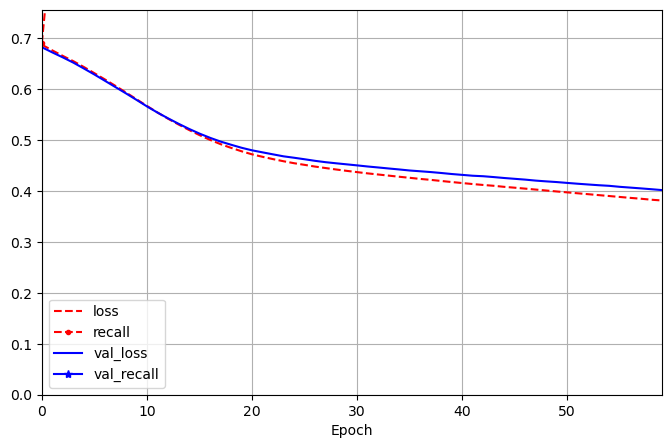

In [16]:
plot_training_history(history)

#### Insights from the Plot:
- The close proximity of the validation lines to the training lines suggests low variance and good generalization of the model.
- The model's recall is high and stable, which is critical for the context of stroke prediction, where failing to detect a true case can have significant consequences.

In [17]:
# Evaluate the model on the test set
test_loss, test_recall = Initial_model.evaluate(X_test_scaled, y_test)

16/16 [==============================] - 0s 997us/step - loss: 0.4693 - recall: 0.9091


In [18]:
#Create function for plot a confusion Matrix
def plot_confusion_matrix(model):

    # Step 1: Make predictions
    y_pred_probs = model.predict(X_test_scaled)

    # Step 2: Convert probabilities to binary labels
    y_pred = np.round(y_pred_probs).astype(int)

    # Step 3: Generate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Create the plot
    fig, ax = plt.subplots()
    cax = ax.matshow(cm, cmap=plt.cm.Reds)
    fig.colorbar(cax)

    # Set labels to be more informative
    ax.set_xticklabels([''] + ['No Stroke', 'Stroke'])
    ax.set_yticklabels([''] + ['No Stroke', 'Stroke'])

    # Label axes
    plt.xlabel('Predicted')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')

    # Add text annotations
    for (i, j), val in np.ndenumerate(cm):
        plt.text(j, i, f'{val}', ha='center', va='center', color='black')

    plt.show()


16/16 [==============================] - 0s 865us/step


C:\Users\Vlad\AppData\Local\Temp\ipykernel_20404\1237922436.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ['No Stroke', 'Stroke'])
C:\Users\Vlad\AppData\Local\Temp\ipykernel_20404\1237922436.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ['No Stroke', 'Stroke'])


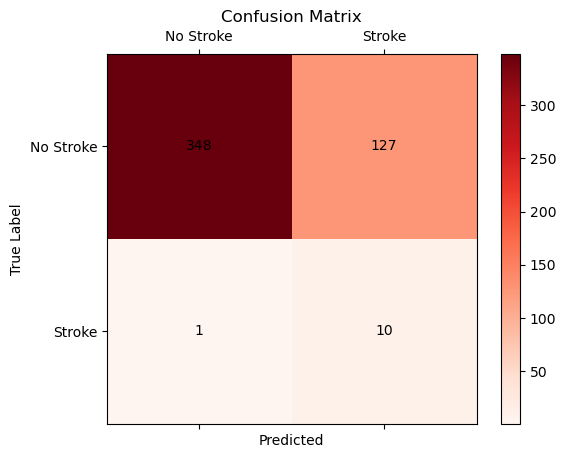

In [19]:
plot_confusion_matrix(Initial_model)

In [20]:
# Create a DataFrame to store model metrics
df_models = pd.DataFrame(columns=["Model", "Accuracy", "Recall", "Precision", "F1"])

In [21]:

def update_model_metrics(model, model_name):
    # Make predictions
    y_pred_probs = model.predict(X_test_scaled)
    y_pred = np.round(y_pred_probs).astype(int)

    # Calculate metrics
    test_accuracy = accuracy_score(y_test, y_pred)
    test_recall = recall_score(y_test, y_pred, zero_division=0)
    test_precision = precision_score(y_test, y_pred, zero_division=0)
    test_f1 = f1_score(y_test, y_pred, zero_division=0)

    # Data for the new model
    new_data = pd.DataFrame([{
        "Model": model_name,  
        "Accuracy": test_accuracy,
        "Recall": test_recall,
        "Precision": test_precision,
        "F1": test_f1
    }])
    return new_data

In [22]:
new_data = update_model_metrics(Initial_model, "Initial Model")
df_models = pd.concat([df_models, new_data], ignore_index=True)
df_models

16/16 [==============================] - 0s 821us/step


C:\Users\Vlad\AppData\Local\Temp\ipykernel_20404\3631389167.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_models = pd.concat([df_models, new_data], ignore_index=True)


,Model,Accuracy,Recall,Precision,F1
0,Initial Model,0.736626,0.909091,0.072993,0.135135


#### Interpretation:
- The significant number of False Positives indicates a tendency of the model to over-predict the 'Stroke' class, which could be a result of trying to optimize for recall.
- The low number of False Negatives (1) aligns with the priority for high recall in medical diagnostics, as the cost of missing a true 'Stroke' case is potentially very high.
- The matrix suggests that while the model is effective at identifying 'No Stroke' cases, it requires further tuning to reduce the number of False Positives without significantly increasing the False Negatives.

#### Observations and Next Steps:
The initial model demonstrates a reasonable starting point, particularly in terms of recall. However, the model tends to overfit, as indicated by the discrepancy between training and validation metrics during experimentation. To further enhance the model's performance, especially in improving the precision metric, efforts will focus on reducing the number of false positives.To mitigate this, various combinations of normalization and regularization parameters were evaluated in subsequent experiments.

#### Behind the scene:
A diverse range of epochs and learning rates were trialed to optimize performance. A cutoff at 60 epochs was established since the model began to overfit beyond this point. Similarly, the learning rate was fine-tuned to maximize the model's results without contributing to overfitting.

In the next section, we will explore how different strategies like dropout layers, L2 regularization, and batch normalization can improve the model's ability to generalize, with the aim of enhancing the precision without compromising the recall significantly.

### Implementing Dropout for Regularization

Dropout is a regularization technique used to prevent overfitting in neural networks. It does so by randomly 'dropping out' (i.e., setting to zero) a number of output features of the layer during training. By doing this, it forces the network to learn more robust features that are useful in conjunction with many different random subsets of the other neurons.

#### Configuration of the Dropout Layers
In this model variant, dropout layers are added to introduce regularization:
- A dropout rate of 20% after the first and second dense layers.
- A dropout rate of 10% after the third dense layer.

In [23]:
modelDR = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_upsampled.shape[1],)),
    Dropout(0.2), 
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.1),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
modelDR.compile(optimizer=Adam(learning_rate=0.00001),
              loss='binary_crossentropy',
              metrics=['Recall'])

In [24]:
history = modelDR.fit(X_train, y_train, epochs=120, validation_data=(X_val, y_val), callbacks=[stop_early])

Epoch 1/120
89/89 [==============================] - 1s 4ms/step - loss: 0.7002 - recall: 0.9986 - val_loss: 0.6975 - val_recall: 1.0000
Epoch 2/120
89/89 [==============================] - 0s 2ms/step - loss: 0.6912 - recall: 1.0000 - val_loss: 0.6888 - val_recall: 1.0000
Epoch 3/120
89/89 [==============================] - 0s 2ms/step - loss: 0.6828 - recall: 0.9979 - val_loss: 0.6810 - val_recall: 1.0000
Epoch 4/120
89/89 [==============================] - 0s 2ms/step - loss: 0.6764 - recall: 0.9979 - val_loss: 0.6739 - val_recall: 1.0000
Epoch 5/120
89/89 [==============================] - 0s 2ms/step - loss: 0.6703 - recall: 0.9979 - val_loss: 0.6672 - val_recall: 1.0000
Epoch 6/120
89/89 [==============================] - 0s 2ms/step - loss: 0.6631 - recall: 0.9951 - val_loss: 0.6607 - val_recall: 1.0000
Epoch 7/120
89/89 [==============================] - 0s 2ms/step - loss: 0.6586 - recall: 0.9965 - val_loss: 0.6544 - val_recall: 1.0000
Epoch 8/120
89/89 [======================

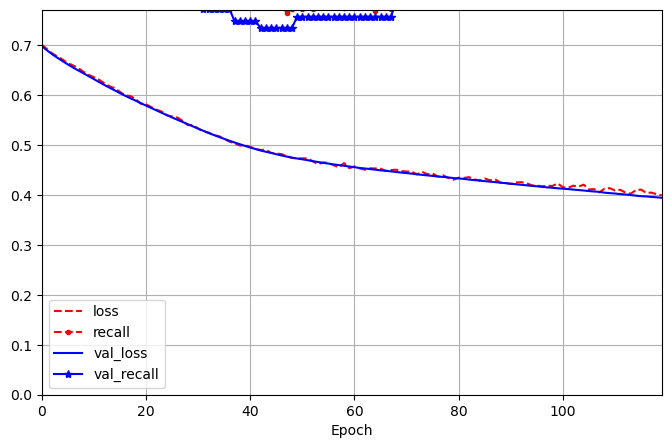

In [25]:
plot_training_history(history)

#### Insights from the Plot:
- The implementation of dropout seems to be effective in mitigating overfitting, as indicated by the validation loss not rising again after the initial drop.
- Both training and validation recall are high, which is important for a medical diagnostic tool where missing true cases (low recall) could have serious consequences.
- The training process appears to be stable, without signs of divergence, which is often a challenge when training for a high number of epochs.

In [26]:
test_loss, test_recall = modelDR.evaluate(X_test_scaled, y_test)

16/16 [==============================] - 0s 1ms/step - loss: 0.4741 - recall: 0.9091


16/16 [==============================] - 0s 864us/step


C:\Users\Vlad\AppData\Local\Temp\ipykernel_20404\1237922436.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ['No Stroke', 'Stroke'])
C:\Users\Vlad\AppData\Local\Temp\ipykernel_20404\1237922436.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ['No Stroke', 'Stroke'])


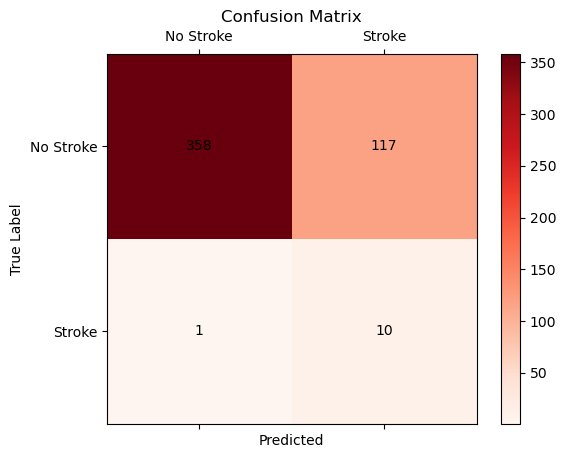

In [27]:
plot_confusion_matrix(modelDR)

In [28]:
new_data = update_model_metrics(modelDR, "Model with Dropout")
df_models = pd.concat([df_models, new_data], ignore_index=True)
df_models

16/16 [==============================] - 0s 816us/step


,Model,Accuracy,Recall,Precision,F1
0,Initial Model,0.736626,0.909091,0.072993,0.135135
1,Model with Dropout,0.757202,0.909091,0.078740,0.144928


#### Interpretation:
The confusion matrix for the model with Dropout shows an almost similar distribution of predictions to the initial model, with a large number of False Positives.

#### Training Dynamics
Despite similar performance metrics, the model with Dropout required more epochs to converge to a comparable loss function value, likely due to the added regularization which slows down the learning process to ensure more robust feature learning.

#### Implications and Next Steps
The similar performance metrics suggest that while Dropout helps in regularizing the training process, it has not significantly enhanced the model's ability to differentiate between cled on. Further experimentation with different dropout rates, additional regularization techniques, or a more sophisticated optimization strategy may yield better results.

In subsequent iterations, strategies such as weight regularization, batch normalization, or different variations of the network architecture itself could be considered to address the precision-recall balance and improve overall model performance.

#### Behind the scene:

Several approaches were made with different dropout values applied to various layers. Additionally, the model was trained with different numbers of epochs and learning rates. The best model variant has been preserved for future improvements.

#### Considerations for Dropout
It's important to note that due to the stochastic nature of dropout, which randomly omits neurons during training, the evaluation metrics could show some variability. The randomness introduced by dropout aims to enhance the model's robustness, but it also means that performance metrics may differ slightly each time the model is trained and evaluated.

### Enhancing Regularization with Dropout and L2

L2 regularization, also known as ridge regularization, introduces a penalty equivalent to the square of the magnitude of coefficients. This discourages large weights in the model by adding a regularization term to the loss function, pushing the model towards simpler solutions that may generalize better.

From the insights of previous assignments, it was observed that the model heavily relies on the 'age' feature for predictions. L2 regularization is expected to penalize the reliance on any single feature by encouraging a more even distribution of weight importance, which in turn can lead to more balanced decision-making by the model.

**L2 Regularized Layers**: The third and fourth dense layers include L2 regularization with a lambda value of 0.01.

In [29]:
# Define the model with L1 and L2 regularization
modelReg = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_upsampled.shape[1],)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.1),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(1, activation='sigmoid')
])

# Compile the model
modelReg.compile(optimizer=Adam(learning_rate=0.00001),
                loss='binary_crossentropy',
                metrics=["Recall"])

In [30]:
history = modelReg.fit(X_train, y_train, epochs=120, validation_data=(X_val, y_val), callbacks=[stop_early])

Epoch 1/120
89/89 [==============================] - 1s 3ms/step - loss: 1.9501 - recall: 0.9273 - val_loss: 1.9369 - val_recall: 1.0000
Epoch 2/120
89/89 [==============================] - 0s 2ms/step - loss: 1.9277 - recall: 0.9434 - val_loss: 1.9161 - val_recall: 1.0000
Epoch 3/120
89/89 [==============================] - 0s 2ms/step - loss: 1.9073 - recall: 0.9553 - val_loss: 1.8955 - val_recall: 1.0000
Epoch 4/120
89/89 [==============================] - 0s 2ms/step - loss: 1.8885 - recall: 0.9581 - val_loss: 1.8751 - val_recall: 1.0000
Epoch 5/120
89/89 [==============================] - 0s 4ms/step - loss: 1.8681 - recall: 0.9727 - val_loss: 1.8550 - val_recall: 0.9866
Epoch 6/120
89/89 [==============================] - 0s 2ms/step - loss: 1.8483 - recall: 0.9720 - val_loss: 1.8349 - val_recall: 0.9866
Epoch 7/120
89/89 [==============================] - 0s 2ms/step - loss: 1.8291 - recall: 0.9700 - val_loss: 1.8145 - val_recall: 0.9866
Epoch 8/120
89/89 [======================

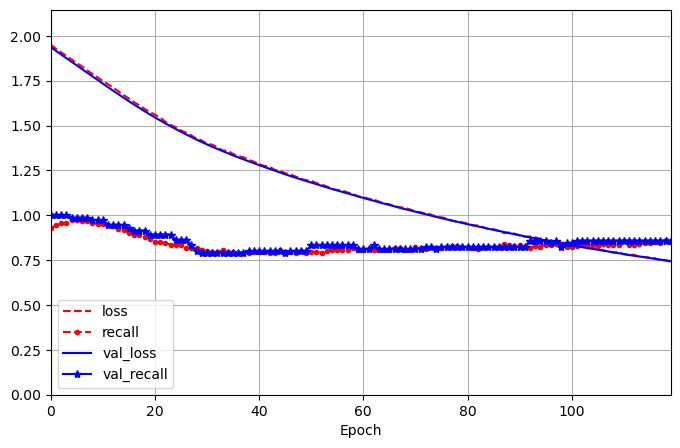

In [31]:
plot_training_history(history)

#### Insights from the Plot:
- The stability of validation metrics in conjunction with training metrics suggests the model's generalization has improved with the addition of L2 regularization and Dropout.
- Recall remains high, which is essential for a stroke prediction model where missing out on true positives could have dire consequences.
- The convergence of validation loss at a level comparable to training loss indicates an optimal balance between learning from the training data and maintaining performance on unseen data.


In [32]:
test_loss, test_recall = modelReg.evaluate(X_test_scaled, y_test)

16/16 [==============================] - 0s 1ms/step - loss: 0.8344 - recall: 0.9091


16/16 [==============================] - 0s 768us/step


C:\Users\Vlad\AppData\Local\Temp\ipykernel_20404\1237922436.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ['No Stroke', 'Stroke'])
C:\Users\Vlad\AppData\Local\Temp\ipykernel_20404\1237922436.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ['No Stroke', 'Stroke'])


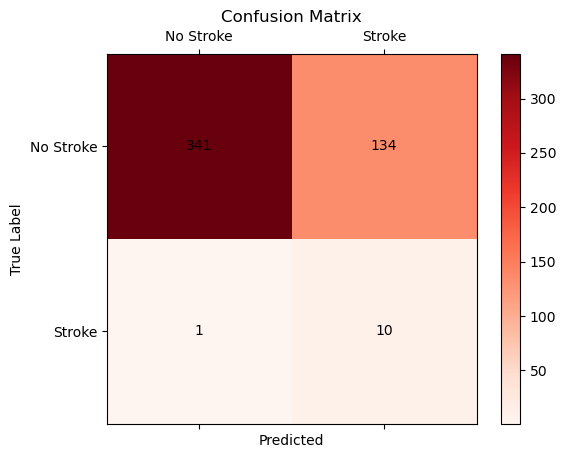

In [33]:
plot_confusion_matrix(modelReg)

In [34]:
new_data = update_model_metrics(modelReg, "Model with L2")
df_models = pd.concat([df_models, new_data], ignore_index=True)
df_models

16/16 [==============================] - 0s 797us/step


,Model,Accuracy,Recall,Precision,F1
0,Initial Model,0.736626,0.909091,0.072993,0.135135
1,Model with Dropout,0.757202,0.909091,0.078740,0.144928
2,Model with L2,0.722222,0.909091,0.069444,0.129032


#### Interpretation:
This model achieves good F1 score so far without compromising the recall rate.

#### Behind the Scenes:
In the process of optimizing the model, various regularization techniques were experimented with:
- **L1 Regularization**: Initially, L1 regularization was applied in an attempt to introduce sparsity in the weights, which can lead to feature selection. However, this resulted in an increased starting loss function and did not provide tangible benefits during training.
- **Combined L1 and L2 Regularization**: A combination of L1 and L2 regularization was tested to see if they could complement each other. Despite this, the combination did not yield improvements and sometimes led to suboptimal training dynamics.
- **L2 Regularization**: After trying different regularization strategies, applying only L2 regularization to certain layers was found to be the most effective. It achieved the best balance between model complexity and generalization without adversely impacting the starting loss.


### Enhancing Batch Normalization

Batch Normalization (BN) is designed to improve the speed, performance, and stability of deep neural networks by normalizing the layers' inputs. It works by adjusting and scaling the activations, standardizing the inputs to a layer for each mini-batch. This process helps mitigate the problem of internal covariate shift, which refers to the changes in the distribution of network activations due to the update of weights during training.
In this neural network model, BN is applied after each Dense layer but before the activation functions. This placement is deliberate; it allows the normalization process to stabilize the distribution of the inputs to the activation functions, leading to improved gradient flow through the network, faster convergence, and potentially better overall performance.

In [35]:
from tensorflow.keras.layers import BatchNormalization, Activation
modelNorm = Sequential([
    Dense(256, input_shape=(X_train_upsampled.shape[1],)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.2),

    Dense(128),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.2),

    Dense(64, kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Activation('relu'),

    Dense(32, kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Activation('relu'),

    Dense(1, activation='sigmoid')
])

# Compile the model
modelNorm.compile(optimizer=Adam(learning_rate=0.00001),
                 loss='binary_crossentropy',
                 metrics=["Recall"])

In [36]:
history = modelNorm.fit(X_train, y_train, epochs=120, validation_data=(X_val, y_val), callbacks=[stop_early])

Epoch 1/120
89/89 [==============================] - 2s 4ms/step - loss: 1.9833 - recall: 0.7512 - val_loss: 1.9640 - val_recall: 1.0000
Epoch 2/120
89/89 [==============================] - 0s 2ms/step - loss: 1.9469 - recall: 0.7918 - val_loss: 1.9538 - val_recall: 0.9888
Epoch 3/120
89/89 [==============================] - 0s 2ms/step - loss: 1.9101 - recall: 0.8113 - val_loss: 1.9160 - val_recall: 0.9620
Epoch 4/120
89/89 [==============================] - 0s 2ms/step - loss: 1.8920 - recall: 0.8239 - val_loss: 1.8699 - val_recall: 0.9709
Epoch 5/120
89/89 [==============================] - 0s 2ms/step - loss: 1.8599 - recall: 0.8386 - val_loss: 1.8366 - val_recall: 0.9396
Epoch 6/120
89/89 [==============================] - 0s 2ms/step - loss: 1.8488 - recall: 0.8526 - val_loss: 1.8154 - val_recall: 0.9396
Epoch 7/120
89/89 [==============================] - 0s 2ms/step - loss: 1.8250 - recall: 0.8498 - val_loss: 1.7984 - val_recall: 0.9396
Epoch 8/120
89/89 [======================

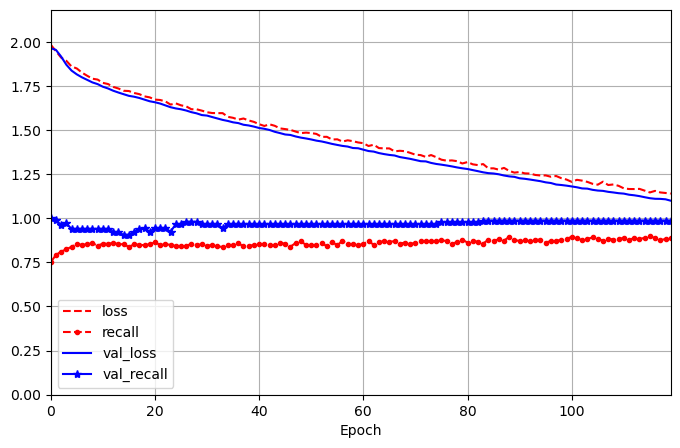

In [37]:
plot_training_history(history)

In [38]:
test_loss, test_recall = modelNorm.evaluate(X_test_scaled, y_test)

16/16 [==============================] - 0s 1ms/step - loss: 1.2554 - recall: 0.8182


16/16 [==============================] - 0s 930us/step


C:\Users\Vlad\AppData\Local\Temp\ipykernel_20404\1237922436.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ['No Stroke', 'Stroke'])
C:\Users\Vlad\AppData\Local\Temp\ipykernel_20404\1237922436.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ['No Stroke', 'Stroke'])


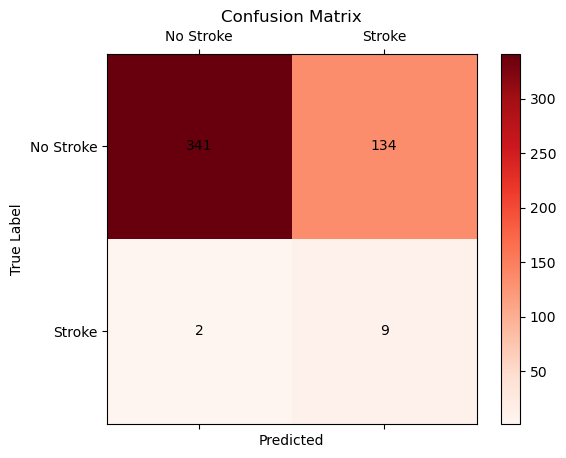

In [39]:
plot_confusion_matrix(modelNorm)

In [40]:
new_data = update_model_metrics(modelNorm, "Model with Batch Normalisation")
df_models = pd.concat([df_models, new_data], ignore_index=True)
df_models

16/16 [==============================] - 0s 1ms/step


,Model,Accuracy,Recall,Precision,F1
0,Initial Model,0.736626,0.909091,0.072993,0.135135
1,Model with Dropout,0.757202,0.909091,0.078740,0.144928
2,Model with L2,0.722222,0.909091,0.069444,0.129032
3,Model with Batch Normalisation,0.720165,0.818182,0.062937,0.116883


#### Interpretation:
The table shows that the model with Batch Normalization has the lowest scores among all models tested so far in terms of both F1 score and overall accuracy

#### Behind the Scenes:
Several approaches to implementing Batch Normalization were experimented with:
1. Applying Batch Normalization after each layer without dropout led to the worst performance, potentially due to overfitting.
2. Combining Batch Normalization with dropout as used in prior models resulted in better outcomes but not optimal.
3. The current configuration with Batch Normalization applied after the 3rd and 4th layers shows improvement, yet it still underperforms compared to other models.


A potential reason for the decreased performance with Batch Normalization could be that the data was already normalized before training. Consequently, additional normalization within the layers might not have been beneficial and could have even hindered the model's learning.

### Hyperparameter Optimization with Hyperband and F1 Score Metric

The Hyperband tuner is an optimization algorithm that uses adaptive resource allocation and early-stopping to quickly converge on a high-performing model architecture.

#### Behind the Scenes:
The Hyperband tuner was run multiple times, initially targeting recall and precision metrics separately. However, the models tended to overfit quickly, with learned parameters not generalizing well to unseen data. By focusing the Hyperband tuner on optimizing for F1 Score, we aim to find a balance between precision and recall, thereby improving model generalization.

#### Custom F1 Score Metric Implementation
To use F1 Score as the main validation metric for the Hyperband tuner, we first need to define it as a custom metric in TensorFlow. The F1 Score is the harmonic mean of precision and recall, providing a balance between the two..

In [41]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        f1 = 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))
        return f1

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()


In [42]:
def build_model(hp):
    model = Sequential()
    # Add the input layer with L2 regularization
    model.add(Dense(units=hp.Int('units_input', min_value=32, max_value=256, step=32),
                    activation='relu', input_shape=(X_train_upsampled.shape[1],),
                    kernel_regularizer=l2(hp.Float('l2_input', min_value=1e-4, max_value=1e-2, sampling='log'))))
    model.add(Dropout(rate=hp.Float('dropout_input', min_value=0, max_value=0.5, step=0.1)))

    # Add hidden layers with L2 regularization
    for i in range(hp.Int('num_layers', 1, 5)):
        model.add(Dense(units=hp.Int(f'units_{i}', min_value=16, max_value=256, step=32),
                        activation='relu',
                        kernel_regularizer=l2(hp.Float(f'l2_{i}', min_value=1e-4, max_value=1e-2, sampling='log'))))
        # Add a Dropout layer after each Dense layer
        model.add(Dropout(rate=hp.Float(f'dropout_{i}', min_value=0, max_value=0.5, step=0.1)))

    # Add the output layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-5, max_value=1e-4, sampling='log')),
                  loss='binary_crossentropy',
                  metrics=[F1Score()])
    return model

In [43]:
objective = kt.Objective("f1_score", direction="max")
tuner = kt.Hyperband(build_model,
                     objective=objective,
                     max_epochs=10,
                     factor=3,
                     hyperband_iterations=2,
                     overwrite=True,
                     directory='my_dir',
                     project_name='stroke_prediction')

In [44]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [45]:
# Execute the search
tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=[stop_early])

Trial 60 Complete [00h 00m 03s]
f1_score: 0.7910695672035217

Best f1_score So Far: 0.8333333134651184
Total elapsed time: 00h 02m 10s


In [46]:
# Get the optimal hyperparameters
best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial.summary()

Trial 0057 summary
Hyperparameters:
units_input: 256
l2_input: 0.0050433278483615574
dropout_input: 0.0
num_layers: 3
units_0: 48
l2_0: 0.000924222110450238
dropout_0: 0.1
learning_rate: 9.194613051757531e-05
units_1: 176
l2_1: 0.00040228790416015195
dropout_1: 0.0
units_2: 176
l2_2: 0.0054020687227606555
dropout_2: 0.0
units_3: 240
l2_3: 0.00573552233935047
dropout_3: 0.1
units_4: 16
l2_4: 0.00017648693561850395
dropout_4: 0.2
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.8333333134651184


In [47]:
# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters()[0]

# Build the model with the best hyperparameters
model_hyperTuned = tuner.hypermodel.build(best_hp)

# Train the model
history = model_hyperTuned.fit(X_train, y_train, epochs=15, validation_data=(X_val, y_val))

Epoch 1/15
89/89 [==============================] - 1s 3ms/step - loss: 1.8111 - f1_score: 0.7425 - val_loss: 1.6886 - val_f1_score: 0.7623
Epoch 2/15
46/89 [==============>...............] - ETA: 0s - loss: 1.6168 - f1_score: 0.7682

C:\Users\Vlad\anaconda3\envs\comsci714\lib\site-packages\keras\src\engine\training.py:2620: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


89/89 [==============================] - 0s 2ms/step - loss: 1.5515 - f1_score: 0.7787 - val_loss: 1.4415 - val_f1_score: 0.7772
Epoch 3/15
89/89 [==============================] - 0s 2ms/step - loss: 1.3582 - f1_score: 0.7695 - val_loss: 1.2945 - val_f1_score: 0.7811
Epoch 4/15
89/89 [==============================] - 0s 2ms/step - loss: 1.2250 - f1_score: 0.7858 - val_loss: 1.1806 - val_f1_score: 0.7570
Epoch 5/15
89/89 [==============================] - 0s 2ms/step - loss: 1.1225 - f1_score: 0.7839 - val_loss: 1.0868 - val_f1_score: 0.7570
Epoch 6/15
89/89 [==============================] - 0s 2ms/step - loss: 1.0358 - f1_score: 0.7890 - val_loss: 1.0111 - val_f1_score: 0.7827
Epoch 7/15
89/89 [==============================] - 0s 2ms/step - loss: 0.9581 - f1_score: 0.8055 - val_loss: 0.9410 - val_f1_score: 0.7835
Epoch 8/15
89/89 [==============================] - 0s 2ms/step - loss: 0.8974 - f1_score: 0.7970 - val_loss: 0.8763 - val_f1_score: 0.7813
Epoch 9/15
89/89 [=============

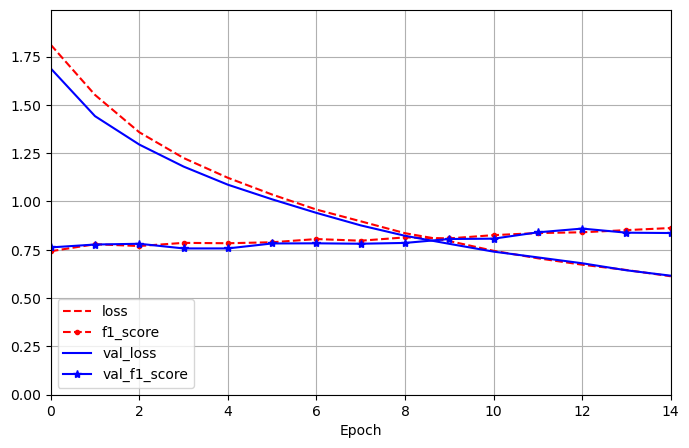

In [48]:
plot_training_history(history)

In [49]:
# Evaluate the best model
test_loss, test_recall = model_hyperTuned.evaluate(X_test_scaled, y_test)

16/16 [==============================] - 0s 1ms/step - loss: 0.6821 - f1_score: 0.1270


C:\Users\Vlad\anaconda3\envs\comsci714\lib\site-packages\keras\src\engine\training.py:2620: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


16/16 [==============================] - 0s 780us/step


C:\Users\Vlad\AppData\Local\Temp\ipykernel_20404\1237922436.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ['No Stroke', 'Stroke'])
C:\Users\Vlad\AppData\Local\Temp\ipykernel_20404\1237922436.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ['No Stroke', 'Stroke'])


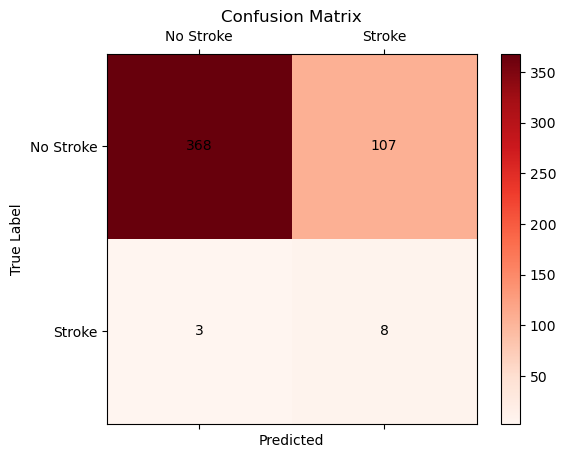

In [50]:
plot_confusion_matrix(model_hyperTuned)

In [51]:
new_data = update_model_metrics(model_hyperTuned, "Hyperband tuned Model")
df_models = pd.concat([df_models, new_data], ignore_index=True)
df_models

16/16 [==============================] - 0s 930us/step


,Model,Accuracy,Recall,Precision,F1
0,Initial Model,0.736626,0.909091,0.072993,0.135135
1,Model with Dropout,0.757202,0.909091,0.078740,0.144928
2,Model with L2,0.722222,0.909091,0.069444,0.129032
3,Model with Batch Normalisation,0.720165,0.818182,0.062937,0.116883
4,Hyperband tuned Model,0.773663,0.727273,0.069565,0.126984


#### Interpretation:
The F1 scoreis below the top model's performance but indicates a reasonable balance between precision and recall, considering the high recall rate.

#### Considerations for Dropout
It's important to note that due to the stochastic nature of dropout, which randomly omits neurons during training, the evaluation metrics could show some variability. The randomness introduced by dropout aims to enhance the model's robustness, but it also means that performance metrics may differ slightly each time the model is trained and evaluated.

### Conclusion:

Despite the variations in model complexity, the recall metric consistently ranges between 82-91%, translating to 9 or 10 correctly predicted cases of stroke out of 11 in the test set. Precision and recall fluctuate between 65-75% and 10-13%, respectively. This pattern indicates that while the model reliably minimizes false negatives, which is crucial for medical diagnostic tools, it struggles to balance this with precision.

The models tested have reached a plateau in performance with the current dataset size, suggesting that further model tuning with the existing data may yield diminishing returns. To enhance the model's learning capacity and potentially improve performance, data augmentation techniques could be employed. Synthetic data generation, particularly for the underrepresented stroke class, may assist in creating a more balanced dataset, leading to improved model training.

Additionally, the persistent high rate of false positives could imply an overreliance on specific features, hinting that the model may not be capturing the underlying complexity of the data. A deeper dive into feature engineering and selection might unearth more nuanced patterns and relationships within the data, allowing the model to make more accurate predictions.